# Packages and functions import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Packages

In [ ]:
import pandas as pd, numpy as np
import os, sys, requests, json
from datetime import datetime, timedelta

from pandas_datareader import DataReader as pdr
#from drive.MyDrive.py.python_mafe.pymafe.mafe import MAFE
#from drive.MyDrive.py.app.stock_api import * # stock api
file_folder = os.path.join('/content', 'drive', 'MyDrive', 'py', 'python_mafe');

from warnings import filterwarnings
filterwarnings('ignore');

import seaborn as sns
from matplotlib import pyplot as plt

def plt_setting():
    from matplotlib import font_manager
    plt.rcParams['font.size'] = 14;
    plt.rcParams['figure.figsize'] = (21, 9); #plot_size;
    plt.rcParams['grid.linestyle'] = ':';
    plt.rcParams['grid.linewidth'] = 0.8;
    plt.rcParams['axes.formatter.useoffset'] = False;
    plt.rcParams['axes.grid'] = True;
    plt.rcParams['ytick.labelright'] = True;
    plt.rcParams['ytick.labelleft'] = False;
    return None

plt_setting();


## Functions and modules

In [ ]:
class MAFE():
    
    def __init__(
        self, 
        ohlc: pd.Series, 
        entry: pd.Series, 
        exit: pd.Series, 
        long_short: str
        #atr_window: int,
        ):
        self.LS = 'S' if ('s' in long_short) or ('S' in long_short) else 'L';
        self.ohlc = ohlc;
        self.entry = entry;
        self.exit = exit;
        self.tr = pd.DataFrame({
            'ch': (ohlc['close'].shift() - ohlc['high']).abs(),
            'cl': (ohlc['close'].shift() - ohlc['low']).abs(),
            'hl': (ohlc['high'] - ohlc['low']),
            }).max(axis=1);
        self.atr_window = 20;
        self.atr = self.tr.rolling(self.atr_window).mean();
        self.atr_entry = self.atr[entry];
        
    def pnl(self):
        ohlc = self.ohlc;
        entry = self.entry;
        exit = self.exit;
        entry_price = ohlc.loc[entry]['open'].reset_index(drop=True);
        exit_price = ohlc.loc[exit]['open'].reset_index(drop=True);
        return (
            (exit_price - entry_price) * int(self.LS == 'L')
            + (- exit_price + entry_price) * int(self.LS == 'S')
        ).rename('PnL')
        
    def _ae(self):
        ohlc = self.ohlc;
        entry = self.entry;
        exit = self.exit;

        return {
            i: 
            # if long entry
            (- ohlc.loc[entry].iloc[i]['open']
                + ohlc[(ohlc.index >= entry.iloc[i]) & (ohlc.index <= exit.iloc[i])]['low']
                ).apply(lambda x: min(0, x)) * int(LS == 'L') * -1
            +
            # if short entry
            (+ ohlc.loc[entry].iloc[i]['open']
                - ohlc[(ohlc.index >= entry.iloc[i]) & (ohlc.index <= exit.iloc[i])]['high']
                ).apply(lambda x: min(0, x)) * int(LS == 'S') * -1
            for i in range(len(entry))
        }

    def _fe(self):
        ohlc = self.ohlc;
        entry = self.entry;
        exit = self.exit;

        return {
            i: 
            # if long entry
            (- ohlc.loc[entry].iloc[i]['open']
                + ohlc[(ohlc.index >= entry.iloc[i]) & (ohlc.index <= exit.iloc[i])]['high']
                ).apply(lambda x: max(0, x)) * int(LS == 'L')
            +
            # if short entry
            (+ ohlc.loc[entry].iloc[i]['open']
                - ohlc[(ohlc.index >= entry.iloc[i]) & (ohlc.index <= exit.iloc[i])]['low']
                ).apply(lambda x: max(0, x)) * int(LS == 'S')
            for i in range(len(entry))
        }

    def _fe_lv(self, td, lv):
        try:
            if lv == 0:
                return self._fe()[td].dropna()
            if lv > 0:
                mae_time = self._ae_lv(td, lv - 1).rank(method='dense', ascending=False).sort_values().index[lv - 1];
                return self._fe()[td][mafe._fe()[td].index < mae_time].dropna();
        except:
            return self._fe()[td].dropna().iloc[0]

    def _ae_lv(self, td, lv):
        try:
            if lv == 0:
                return self._ae()[td].dropna()
            if lv > 0:
                mfe_time = self._fe_lv(td, lv - 1).rank(method='dense', ascending=False).sort_values().index[lv - 1];
                return self._ae()[td][mafe._ae()[td].index < mfe_time].dropna();
        except:
            return self._ae()[td].dropna().iloc[0]

    def mae(self, lv=0):
        return {td: self._ae_lv(td, lv).max() for td in range(len(self.entry))}

    def mfe(self, lv=0):
        return {td: self._fe_lv(td, lv).max() for td in range(len(self.entry))}

    def eda(_plot=True): # Exploratory Data Analysis
        data = pd.DataFrame({
            'PnL': mafe.pnl(),
            'MAE': pd.Series(mafe.mae(0)),
            'MFE': pd.Series(mafe.mfe(1)),
            'cMFE': pd.Series(mafe.mfe(0)),
        }).fillna(0)
        if _plot:
            data.hist(bins=25);
            data.plot.scatter(x='PnL', y='MAE');
            data.plot.scatter(x='PnL', y='MFE');
            data.plot.scatter(x='MAE', y='MFE');
        return data

    

SyntaxError: ignored

In [ ]:
class StockDataAPI():
    
    def __init__(
            self, 
            stock_code: str, 
            start: datetime=datetime(2010, 1, 1), 
            end: datetime=datetime.now(),
            ):
        self.now = datetime.now();
        self.stock_code = str(stock_code);
        self.start = start; 
        self.end = end;

    def get_fin_data(self):
    
        def get_data(stock_code, start, end):
    
            url = ('https://statementdog.com/api/v1/fundamentals/' + str(stock_code) + '/' 
               + str(start.year) + '/' + str(int(start.month/4 + 1)) + '/'
               + str(end.year) + '/' + str(int(end.month/4 + 1)) + '/'
               + 'cf?qub=true&qf=analysis');
            
            res = requests.get(url);
            
            return res.json()
        
        def _parse_data(data, freq):
            _data_dict = {};
            for key, value in data[freq].items():
                try:
                    _data_dict[value['label']] = (
                        pd.DataFrame(value['data'], columns=['index', key])[key]
                        );
                except:
                    None
            
            return pd.DataFrame(_data_dict);
        
        # monthly data
        def _data_m(data):
            
            df = _parse_data(data, 'monthly');
            ori_columns = list(df.columns);
            df['date'] = (
                pd.DataFrame(data['common']['TimeM']['data'])[1]
                .astype(str)
                .apply(lambda x: 
                       (datetime(int(x[:4]), (int(x[-2:]) + 1), 1) if x[-2:] != '12' 
                        else datetime(int(x[:4]) + 1, 1, 1))
                       - timedelta(1))
                );
            ticker_name = data['common']['StockInfo']['data']['ticker_name'];
            df['stock_code'] = ticker_name.split(' ')[0];
            df['stock_name'] = ticker_name.split(' ')[1];
            
            return (df[['stock_code', 'stock_name', 'date'] + ori_columns]
                    .dropna(how='all', axis=1).replace('無', np.nan))
        
        # quarterly data
        def _data_q(data):
            
            df = _parse_data(data, 'quarterly');
            ori_columns = list(df.columns);
            df['date'] = (
                pd.DataFrame(data['common']['TimeQ']['data'])[1]
                .astype(str)
                .apply(lambda x: 
                       (datetime(int(x[:4]), (int(x[-1:]) * 3 + 1), 1) if x[-1:] != '4' 
                        else datetime(int(x[:4]) + 1, 1, 1))
                       - timedelta(1))
                );
            
            ticker_name = data['common']['StockInfo']['data']['ticker_name'];
            df['stock_code'] = ticker_name.split(' ')[0];
            df['stock_name'] = ticker_name.split(' ')[1];
            
            return (df[['stock_code', 'stock_name', 'date'] + ori_columns]
                    .dropna(how='all', axis=1).replace('無', np.nan))
        
        # yearly data
        def _data_y(data):
            
            df = _parse_data(data, 'yearly');
            ori_columns = list(df.columns);
            df['date'] = (
                pd.DataFrame(data['common']['TimeY']['data'])[1].astype(str)
                .apply(lambda x: datetime(int(x[:4]), 12, 31)));
            
            ticker_name = data['common']['StockInfo']['data']['ticker_name'];
            df['stock_code'] = ticker_name.split(' ')[0];
            df['stock_name'] = ticker_name.split(' ')[1];
            
            return (df[['stock_code', 'stock_name', 'date'] + ori_columns]
                    .dropna(how='all', axis=1).replace('無', np.nan))
        
        data = get_data(self.stock_code, self.start, self.end);
        
        return _data_m(data).set_index('date'), _data_q(data).set_index('date'), _data_y(data).set_index('date')
    
    def get_info(self):
        stock_code = self.stock_code;
        from bs4 import BeautifulSoup as bs
        url = 'https://concords.moneydj.com/z/zc/zca/zca_' + stock_code + '.djhtm';
        res = requests.get(url);
        soup = bs(res.text)
        column_map = {};
        value_map = {};
        content_map = {};
        i = 0;
        for sub_soup in soup.select("td tr tr"):
            column_map[i] = [string.text for string in sub_soup.select(".t4t1")];
            value_map[i] = [string.text for string in sub_soup.select(".t3n1")];
            content_map[i] = [string.text for string in sub_soup.select(".t3t1")];
            i += 1;
        for column_list in column_map.values():
            for value_list in value_map.values():
                content = {
                    key: value 
                    for key in column_list
                    for value in value_list};
        content = pd.concat(
            [pd.Series(column_map).astype(str), 
            pd.Series(value_map), 
            pd.Series(content_map).astype(str)
            ], axis=1)
        content = content.set_index(0);
        content = pd.concat(
            [content[content[1].apply(lambda x: len(x) != 0)][1], 
            content[content[1].apply(lambda x: len(x) == 0)][2]
            ], axis=0);
        content = content[content.index != '[]'];
        return content
    
    def _get_info(self):

        stock_code = self.stock_code;

        def _info(stock_code):
            url = 'https://marketinfo.api.cnyes.com/mi/api/v1/TWS:' + stock_code + ':STOCK/info'
            res = requests.get(url)
            data = pd.Series(res.json()['data'])
            return data

        def _profile(stock_code):
            url = 'https://ws.api.cnyes.com/ws/api/v1/quote/quotes/TWS:' + stock_code + ':STOCK?column=I';
            res = requests.get(url);
            data = res.json()['data'];
            mapping = {
                '0': 'ticker',
                '6': 'close',
                '11': 'price_change',
                '12': 'day_high',
                '13': 'day_low',
                '19': 'open',
                '21': 'last_close',
                '56': 'price_change_pct',
                '3265': '1_year_high',
                '3266': '1_year_low',
                '200007': 'date',
                '200009': 'stock_name',
                '200010': 'stock_code',
                '200024': 'stock_name_eng',
                '700001': 'pe_ratio',
                '700005': 'market_value',
                '700006': 'pb_ratio',
                '800001': 'trading_volume',
                '800013': 'ticker_2',
            }
            data = pd.Series(data[0]);
            data.index = pd.Series(data.index).replace(mapping);
            data = data.sort_index();

            return data
        
        return pd.concat([_info(stock_code), _profile(stock_code)], sort=False)

    def get_ohlc(self, freq='D'):
        stock_code = self.stock_code;
        url_domain = 'https://ws.api.cnyes.com/ws/api/v1/charting/history';
        end = datetime(self.now.year, self.now.month, self.now.day);
        start = end - timedelta(365 * 20);
        url = (
            url_domain + 
            '?resolution=D' + #freq + 
            '&symbol=TWS:' + stock_code + ':STOCK' + 
            '&from=' + str(int(end.timestamp())) + 
            '&to=' + str(int(start.timestamp())) +
            '&quote=1'
            );
        res = requests.get(url);
        data = res.json()['data'];
        df = pd.DataFrame({
            'open': data['o'],
            'high': data['h'],
            'low': data['l'],
            'close': data['c'],
            'volume': data['v']}, 
            index=pd.Series(data['t']).apply(
                lambda x: datetime.fromtimestamp(x) + 
                (timedelta(8/24) if freq == '1' else timedelta(0))
                )
            );
        df = df.resample(freq).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum',
            }).dropna();
        return df[['open', 'high', 'low', 'close', 'volume']]
    
    def get_ohlc_std(self):
        stock_code = self.stock_code;
        df = self.get_ohlc(stock_code);
        df['volume'] = df['volume'] * 1000 * df['close'];
        df[['open', 'high', 'low', 'close']] = (
            df[['open', 'high', 'low', 'close']]/df['open'].iloc[0] * 10);
        return df

    def plot_kchart(self, start=None, end=None, freq: str='D', volume_on: bool=True, save_graph: bool=False, graph_style: str='nightclouds'):
        
        import mplfinance as mpf
        
        title = str(self.stock_code);

        if end == None:
            end = datetime(self.now.year, self.now.month, self.now.day);
        
        if start == None:
            start = end - timedelta(365 * 20);

        ohlc_data = self.get_ohlc(freq=freq);
        ohlc_data = ohlc_data[(ohlc_data.index >= start) & (ohlc_data.index <= end)];
        
        """
        Parameters
        ----------         
        volume_on : bool, optional
            draw volume or not. The default is True.
            
        graph_style : str, optional
            ohlc graph style. ['binance', 'blueskies', 'brasil', 'charles', 
            'checkers', 'classic', 'default', 'mike', 'nightclouds', 
            'sas', 'starsandstripes', 'yahoo'] are available styles
            
        Returns
        -------
        freq ohlc dataframe.
        """

        if 'volume' not in ohlc_data.columns:
            volume_on = False;
        if title == None:
            title = ohlc_data.index.max().strftime('%Y-%m-%d');
        
        market_colors = mpf.make_marketcolors(# 设置marketcolors
            up='red', down='white', edge='i', # edge:K线线柱边缘颜色(i代表继承自up和down的颜色)
            wick={'up':'red', 'down':'white'}, # wick:灯芯(上下影线)颜色
            volume='in', inherit=True, # # volume:成交量直方图的颜色 inherit:是否继承，选填
            );
        
        mpf_graph_style = mpf.make_mpf_style( # 设置图形风格
            base_mpf_style=graph_style, marketcolors=market_colors, #mpf.available_styles()
            y_on_right=True, # y_on_right:设置y轴位置是否在右
            gridaxis='both', gridstyle=':', # gridaxis:设置网格线位置 # gridstyle:设置网格线线型
            );
        
        kwargs = dict( # 设置基本参数
            type='candle', # type:绘制图形的类型，有candle, renko, ohlc, line等	
            volume=volume_on, # volume:布尔类型，设置是否显示成交量，默认False
            title=title, # title:设置标题
            ylabel='ohlc', ylabel_lower='volume', # y_label_lower:设置成交量图一栏的标题
            figscale=1, # figscale:设置图形尺寸(数值越大图像质量越高)
            figratio=(16, 9), # figratio:设置图形纵横比
            );
        if save_graph:
            plt.rcParams['font.size'] = 48;
            plt.rcParams['figure.figsize'] = (108, 72); #plot_size;
            plt.rcParams['grid.linestyle'] = ':';
            plt.rcParams['grid.linewidth'] = 3;
            plt.close();
            mpf.plot(data=kline_data, style=mpf_graph_style, **kwargs, 
                    savefig=os.path.join(file_path, 'kline', title + '.jpg'));
            plt_setting();
        if ~save_graph:
            mpf.plot(data=kline_data, style=mpf_graph_style, **kwargs)


# Example

In [ ]:
#%%
def ma_cross(ohlc, w_1=5, w_2=20, w_3=60):
    sma_1 = ohlc['close'].rolling(w_1).mean();
    sma_2 = ohlc['close'].rolling(w_2).mean();
    sma_3 = ohlc['close'].rolling(w_3).mean();

    cond_LE = (
        (sma_1 >= sma_2) & (sma_1.shift() < sma_2.shift()) 
    #    & (ohlc['close'] > sma_3) 
    ).shift().fillna(False);

    cond_LX = (
        ((sma_1 < sma_2) & (sma_1.shift() >= sma_2.shift())) 
    #    | (ohlc['close'] < sma_3)
    ).shift().fillna(False);  
    
    LE = cond_LE[cond_LE].index;
    LX = cond_LX[cond_LX].index;
    LX = [LX[LE[i] <= LX][0] for i in range(len(LE) - 1)];

    LEX = pd.DataFrame({
        'LE': pd.Series(LE),
        'LX': pd.Series(LX),
        }).dropna()

    return LEX, cond_LE, cond_LX

In [ ]:
stock_code = '2377';
api = StockDataAPI(stock_code);
ohlc = api.get_ohlc();
LEX, cond_LE, cond_LX = ma_cross(ohlc);
entry = LEX['LE'];
exit = LEX['LX'];
LS = 'L';

In [ ]:
mafe = MAFE(
    ohlc, 
    entry=LEX['LE'], 
    exit=LEX['LX'], 
    long_short='Long'
);

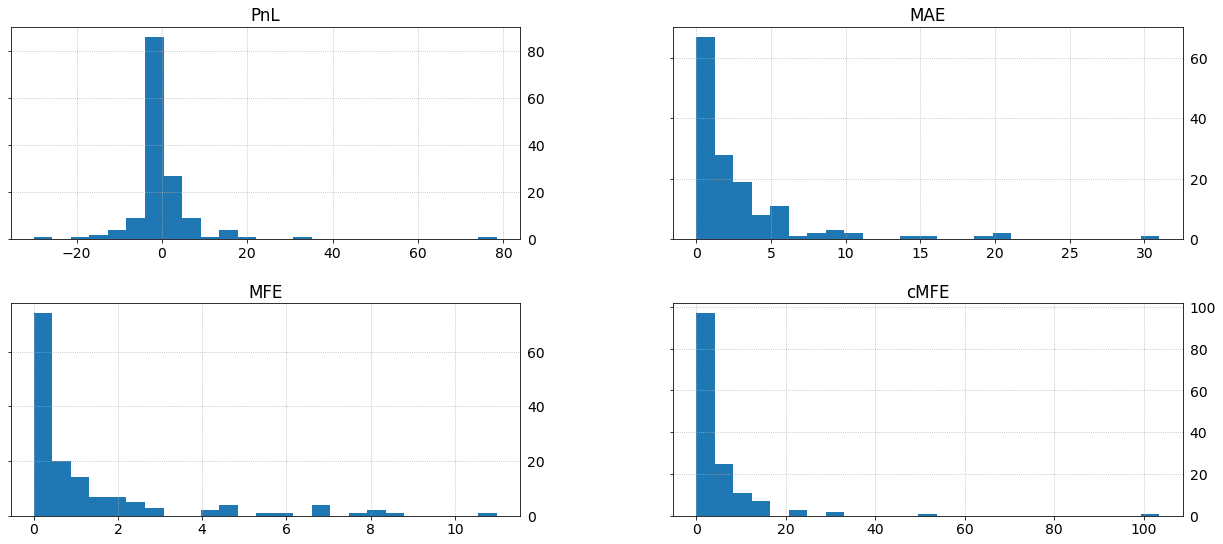

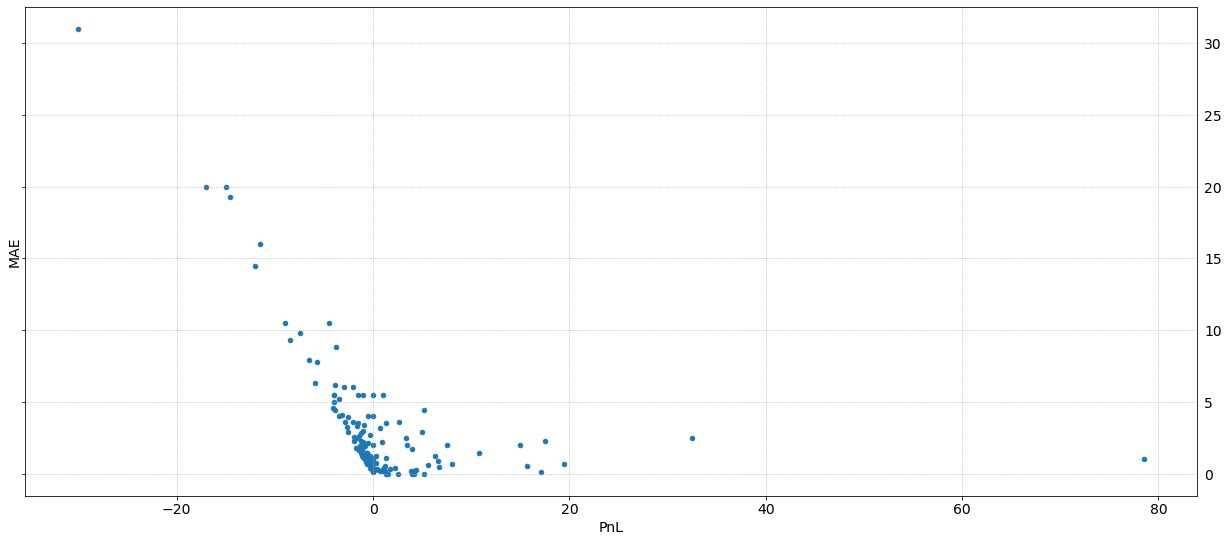

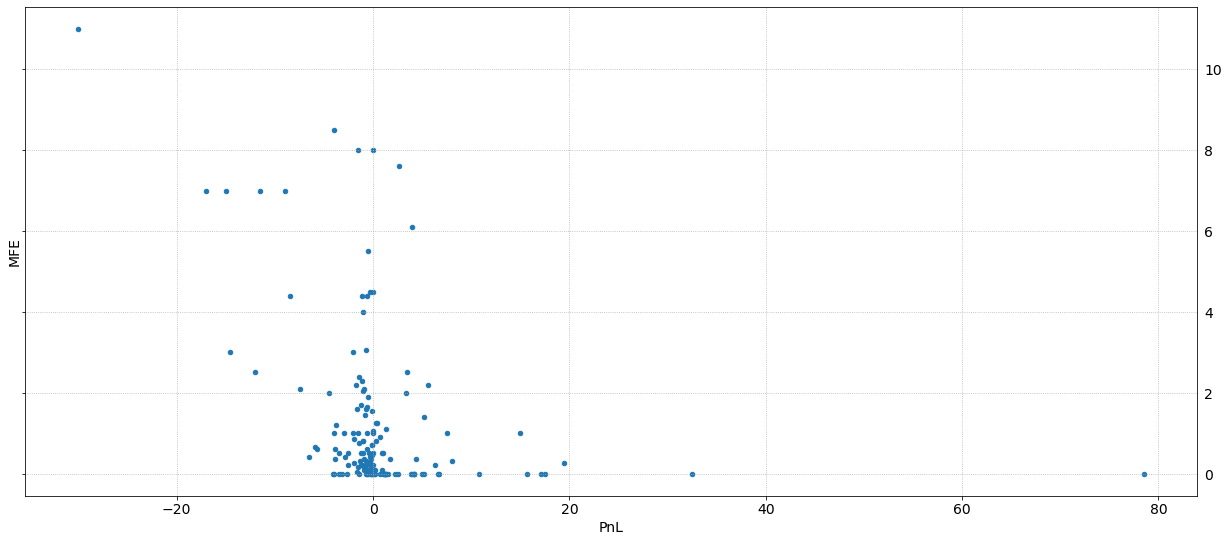

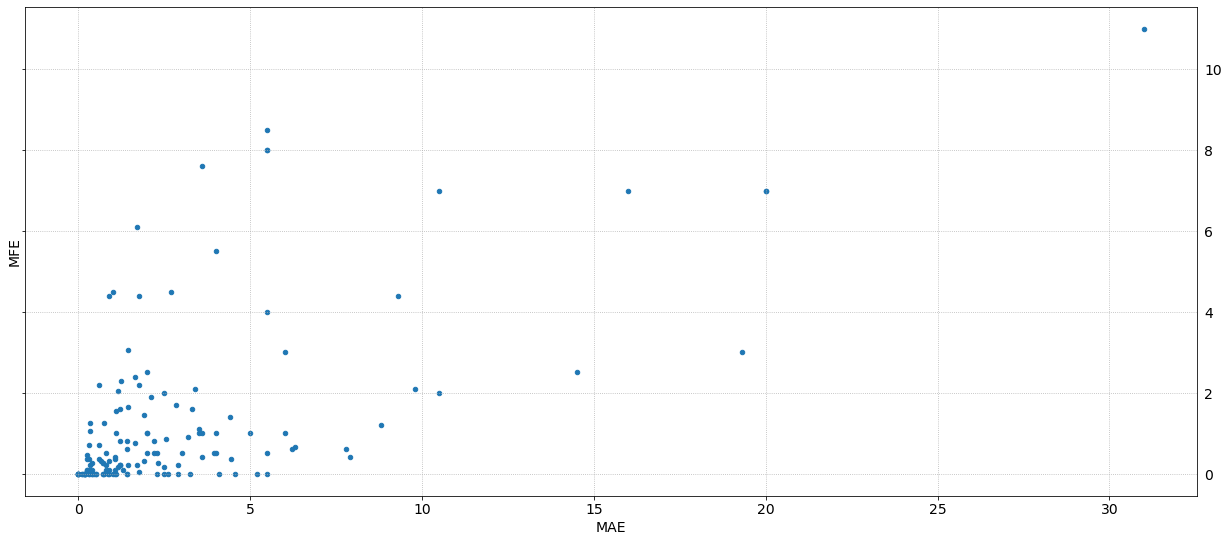

In [ ]:
"""
print(
    mafe.ohlc, '\n',
    mafe.entry, '\n',
    mafe.exit, '\n',
    mafe.LS, '\n',
    mafe.pnl(), '\n',
    mafe._ae(), '\n',
    mafe._fe(), '\n',
    mafe.mae(), '\n',
    mafe.mfe(), '\n',
)
"""
mafe_data = mafe.eda()


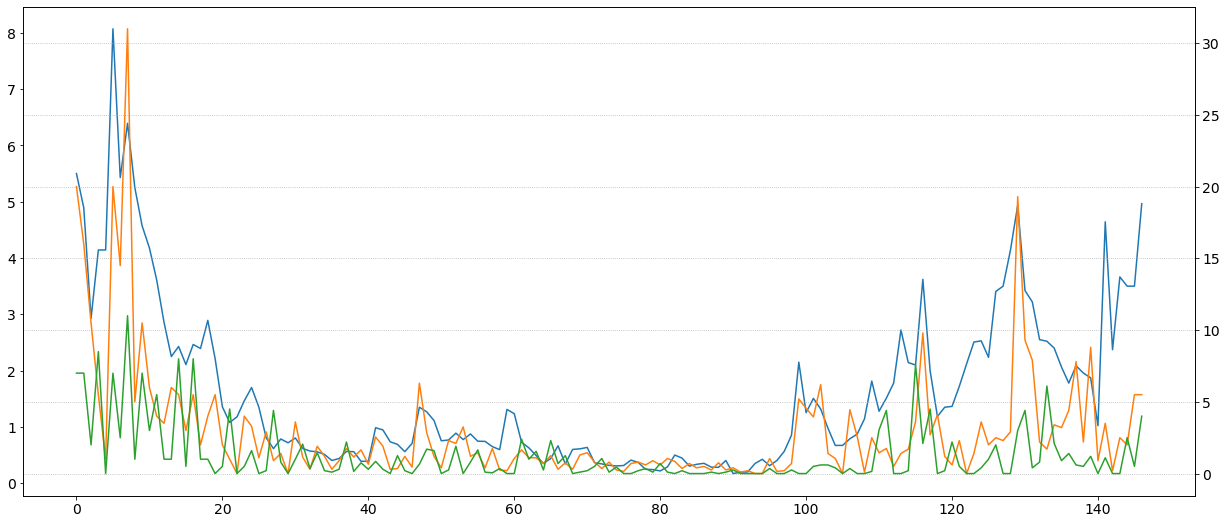

In [ ]:
mafe_data['ATR']
mafe_data['MAE'].plot(secondary_y=True)
mafe_data['MFE'].plot(secondary_y=True)

#temp.hist(bins=25);

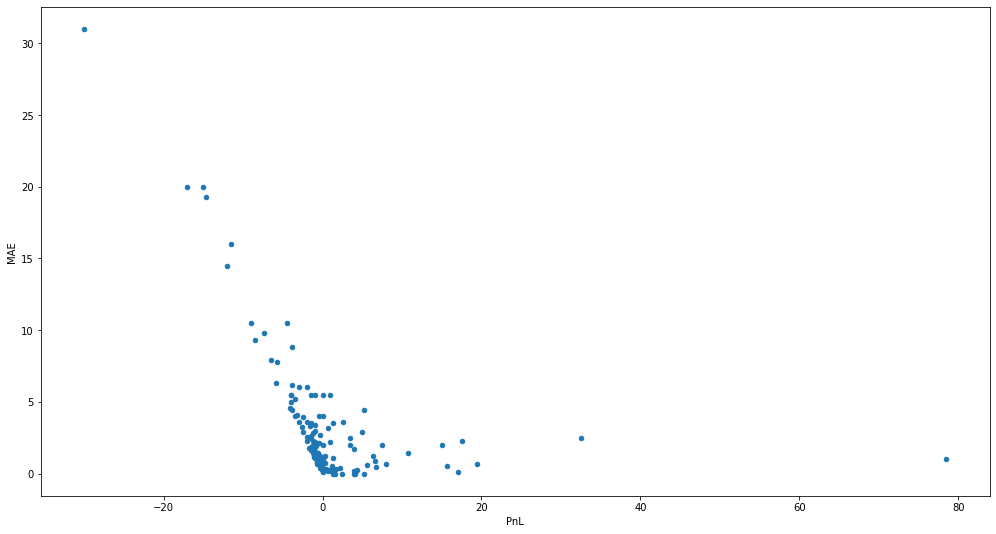

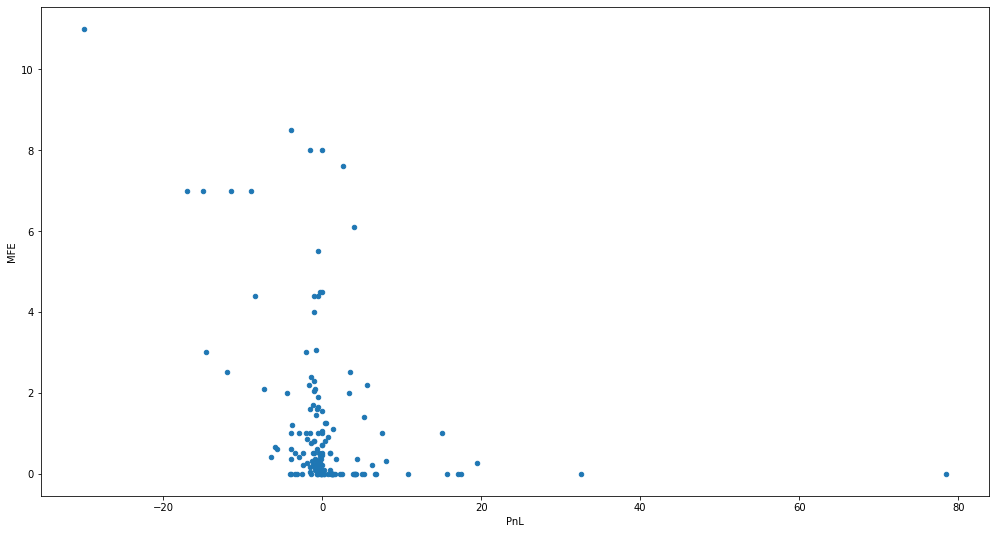

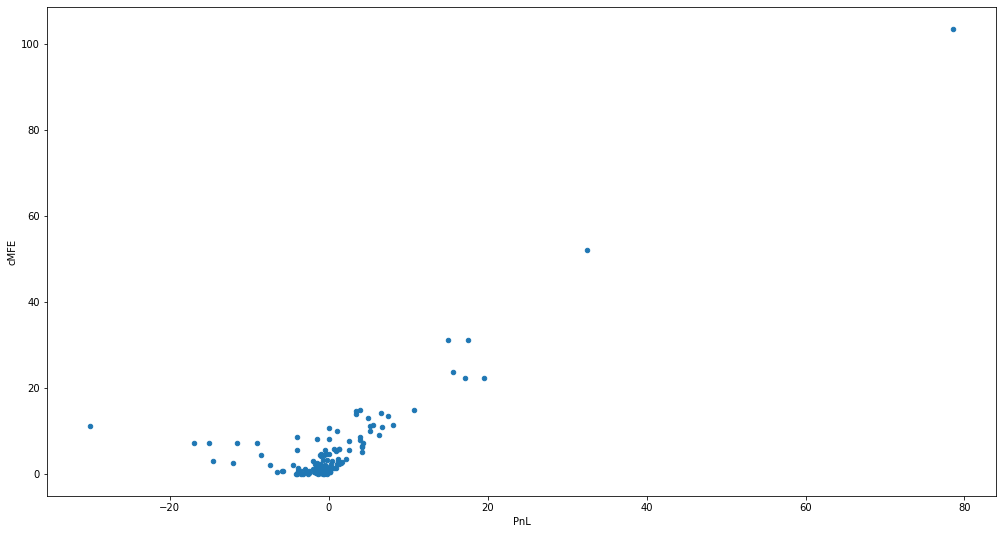

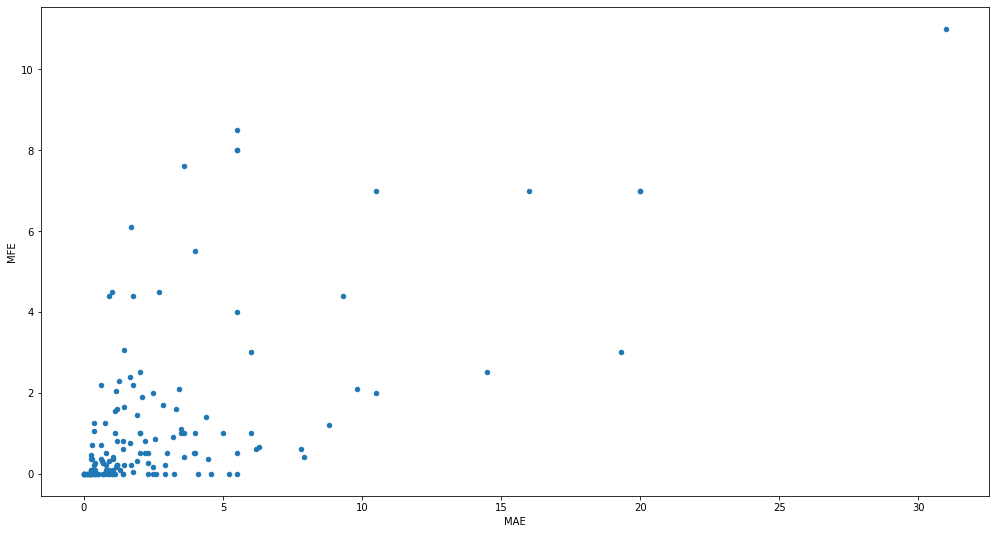

In [ ]:
temp.fillna(0).plot.scatter(x='PnL', y='MAE', figsize=(21, 9));
temp.fillna(0).plot.scatter(x='PnL', y='MFE', figsize=(21, 9));
temp.fillna(0).plot.scatter(x='PnL', y='cMFE', figsize=(21, 9));
temp.fillna(0).plot.scatter(x='MAE', y='MFE', figsize=(21, 9));